# Tutorial of ARC-JSD for Context Attribution

This is a tutorial about how to use our ARC-JSD to locate the most relevant context sentence from the RAG generated resposne.

Installing required libraries first:

In [ ]:
!pip install numpy
!pip install transformers spacy nltk accelerate wheel
!pip install torch torchvision torchaudio

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import nltk
from torch.nn import functional as F
import numpy as np

In [ ]:
nltk.download("punkt_tab")
DEFAULT_GENERATE_KWARGS = {"max_new_tokens": 512, "do_sample": False}
DEFAULT_PROMPT_TEMPLATE = "Context: {context}\n\nQuery: {query}"

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


This is the whole process that how we use ARC-JSD to locate the most relevant context sentence.

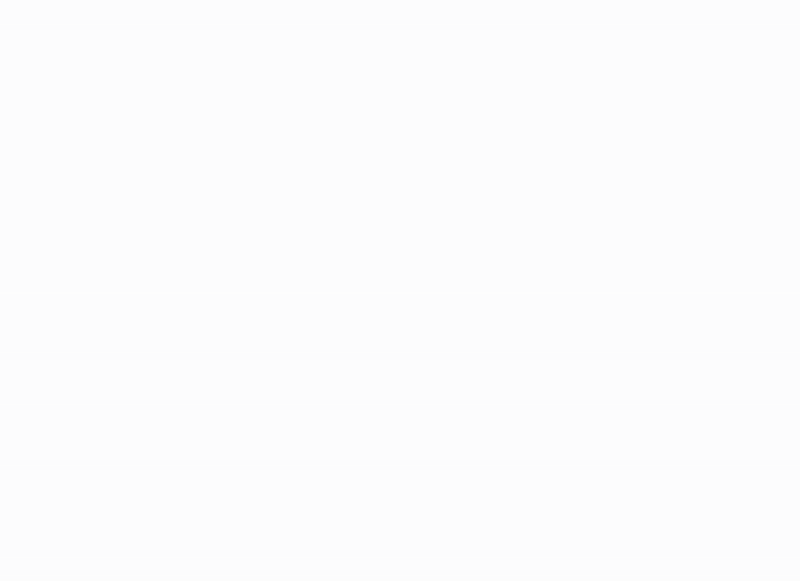

Here, we use Qwen2-1.5B-Instruct model.

In [ ]:
model_name = "Qwen/Qwen2-1.5B-Instruct"

context = """
Attributing Response to Context: A Jensen–Shannon Divergence Driven Mechanistic Study of Context Attribution in Retrieval-Augmented Generation

Abstract
Retrieval-Augmented Generation (RAG) leverages large language models (LLMs) combined with external contexts to enhance the accuracy and reliability of generated responses. However, reliably attributing generated content to specific context segments, context attribution, remains challenging due to the computationally intensive nature of current methods, which often require extensive fine-tuning or human annotation. In this work, we introduce a novel Jensen–Shannon Divergence driven method to Attribute Response to Context (ARC-JSD), enabling efficient and accurate identification of essential context sentences without additional fine-tuning or surrogate modelling. Evaluations on a wide range of RAG benchmarks, such as TyDi QA, Hotpot QA, and Musique, using instruction-tuned LLMs in different scales demonstrate superior accuracy and significant computational efficiency improvements compared to the previous surrogate-based method. Furthermore, our mechanistic analysis reveals specific attention heads and multilayer perceptron (MLP) layers responsible for context attribution, providing valuable insights into the internal workings of RAG models.
"""
query = "Which datasets are used in this paper?"

We initialise Qwen using transformers library.

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            ).eval().to("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"

We difine context partitioner function to preprocess the input context texts using nltk tool.

In [ ]:
def context_partitioner(context, partition_type="sentence"):

    parts = []
    separators = []
    start_indices = []

    for line in context.splitlines():
        if partition_type == "sentence":
            parts.extend(nltk.sent_tokenize(line))
        else:
            raise ValueError(f"Cannot split response by '{partition_type}'")

    cur_start = 0
    for part in parts:
        cur_end = context.find(part, cur_start)
        separator = context[cur_start:cur_end]
        separators.append(separator)
        start_indices.append(cur_end)
        cur_start = cur_end + len(part)

    return parts, separators, start_indices

The get_prompt_id function is used to transfer input texts to tokens.

In [ ]:
def get_prompt_id(context, query, tokenizer):
    prompt = DEFAULT_PROMPT_TEMPLATE.format(context=context, query=query)
    messages = [{"role": "user", "content": prompt}]
    chat_prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    chat_prompt_ids = tokenizer.encode(chat_prompt, add_special_tokens=False)

    return chat_prompt_ids, tokenizer.decode(chat_prompt_ids)

The get_response function is used to generate response based on the input context and query first.

In [ ]:
def get_response(input_context, input_query, tokenizer, model, DEFAULT_GENERATE_KWARGS):
    chat_prompt_ids, chat_prompt = get_prompt_id(input_context, input_query, tokenizer)
    input_ids = torch.tensor([chat_prompt_ids], device=model.device)
    output_ids = model.generate(input_ids, **DEFAULT_GENERATE_KWARGS)[0]


    raw_output = tokenizer.decode(output_ids)

    prompt_length = len(tokenizer.decode(chat_prompt_ids))

    response = raw_output[prompt_length:]
    response_logits = output_ids[prompt_length:]
    return response, tokenizer(response, add_special_tokens=False).input_ids,

The get_ablated_context function is used to build a list of ablated context, where each item of the list ablates single context sentence once a time.

In [ ]:
def get_ablated_context(parts, separators):
    ablated_contexts = []
    mask = (np.ones((len(parts), len(parts))) - np.eye(len(parts))).astype(bool)
    for row_index in range(mask.shape[0]):
        ablated_separators = np.array(separators)[mask[row_index]]
        ablated_parts = np.array(parts)[mask[row_index]]
        context = ""
        for i, (separator, part) in enumerate(zip(ablated_separators, ablated_parts)):
            if i > 0:
                context += separator
            context += part
        ablated_contexts.append(context)
    return ablated_contexts


The full_context_logit is used to return the whole resposne logit when the input context is complete.

In [ ]:
def full_context_logit(input_context, input_query, output_ids):

    ablated_contexts = [input_context]

    for i, ablated_context in enumerate(ablated_contexts):

        ablated_chat_prompt_ids, ablated_chat_prompt = get_prompt_id(ablated_context, input_query, tokenizer)
        ablated_input_ids = torch.tensor([ablated_chat_prompt_ids + output_ids], device=model.device)
        with torch.no_grad():
            ablated_output = model(input_ids=ablated_input_ids)
        logits = ablated_output.logits[:, -(len(output_ids) + 1): -1]

    return logits

The calculate_dist_2d is used to calculate JSD between the ablated context logits and full context logits over the whole reponse content level.

In [ ]:
def calculate_dist_2d(ablated_context_logits, full_context_logits):
    assert ablated_context_logits.shape == full_context_logits.shape, "Logits must have the same shape"

    softmax_ablate = F.softmax(ablated_context_logits, dim=-1)
    softmax_full = F.softmax(full_context_logits, dim=-1)


    M = 0.5 * (softmax_ablate + softmax_full)


    log_softmax_ablate = F.log_softmax(ablated_context_logits, dim=-1)
    log_softmax_full = F.log_softmax(full_context_logits, dim=-1)


    kl1 = F.kl_div(log_softmax_ablate, M, reduction='none').sum(dim=-1)
    kl2 = F.kl_div(log_softmax_full, M, reduction='none').sum(dim=-1)
    js_divs = 0.5 * (kl1 + kl2)

    scores = js_divs.cpu().tolist()

    return sum(scores)

The ablate_context is used to calculate all JSD scores between each ablated context logit and the full context logit.

In [ ]:
def ablate_context(input_context, input_query, input_context_parts, separators, output_ids, model):
    ablated_contexts = get_ablated_context(input_context_parts, separators)


    full_logits = full_context_logit(input_context, input_query, output_ids)


    JSD_div_values = []
    for i, ablated_context in enumerate(ablated_contexts):
        ablated_chat_prompt_ids, _ = get_prompt_id(ablated_context, input_query, tokenizer)
        ablated_input_ids = torch.tensor([ablated_chat_prompt_ids + output_ids], device=model.device)
        with torch.no_grad():
            ablated_output = model(input_ids=ablated_input_ids)
        ablated_logits = ablated_output.logits[:, -(len(output_ids) + 1): -1].bfloat16()


        jsd = calculate_dist_2d(ablated_logits.squeeze(0), full_logits.squeeze(0))
        JSD_div_values.append(jsd)


        del ablated_logits, ablated_output, ablated_input_ids
        torch.cuda.empty_cache()

    return JSD_div_values

### Locate the most relevant context sentence using ARC-JSD

In [ ]:
input_context_parts, separators, _ = context_partitioner(context)

In [ ]:
response, output_ids = get_response(context, query, tokenizer, model, DEFAULT_GENERATE_KWARGS)
JSD_div_values = ablate_context(context, query, input_context_parts, separators, output_ids, model)
JSD_top_index = torch.argmax(torch.tensor(JSD_div_values)).item()
locate_context_sent = input_context_parts[JSD_top_index]

In [ ]:
print(f"Model response: {response}")
print(f"Located top relevant context sentence: {locate_context_sent}")

Model response: The dataset used in this paper is TyDi QA, Hotpot QA, and Musique.<|im_end|>
Located top relevant context sentence: Evaluations on a wide range of RAG benchmarks, such as TyDi QA, Hotpot QA, and Musique, using instruction-tuned LLMs in different scales demonstrate superior accuracy and significant computational efficiency improvements compared to the previous surrogate-based method.
